Naive Bayesian Model
====================

In [1]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.feature_selection as fs
import sklearn.model_selection as mds
import sklearn.naive_bayes as nb

import matplotlib.pyplot as plt
from scipy import interpolate


datestamp = "20250226.185554"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 55)


# Create X and y Frames

In [2]:
# set the features to analyze
#all_columns = True
all_columns = False

if all_columns:
    columns_to_drop = [ "Survived", "Name", "Title", "TitleGrouped", "LastName", "Cabin", 
                        "Ticket", "Sex", "Age", "Embarked", "PassengerId", "CabinDeck",
                        "CabinRoom" ]
    columns_to_drop += []
    x_colnames = [i for i in df_.columns if i not in columns_to_drop]
else:
    x_colnames = [ "TitleOrd", "Pclass", "CabinOrd", "SexOrd", "EmbarkOrd", "AgeImputed", "FarePerPerson" ]

y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values.ravel()

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TitleOrd       891 non-null    float64
 1   Pclass         891 non-null    int64  
 2   CabinOrd       891 non-null    float64
 3   SexOrd         891 non-null    float64
 4   EmbarkOrd      891 non-null    float64
 5   AgeImputed     891 non-null    float64
 6   FarePerPerson  891 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 48.9 KB
None


# Create Test and Train Datasets

In [3]:
# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

# Feature Scoring

In [4]:
f_model = fs.SelectKBest(fs.chi2, k=3)
f_model.fit_transform(X_train, y_train)

scores = f_model.scores_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'chi2 Scores': scores} ).sort_values(
         'chi2 Scores', ascending=False)
print(feature_imp_df)

         Feature  chi2 Scores
6  FarePerPerson  2004.833274
0       TitleOrd   458.753418
2       CabinOrd   153.968243
3         SexOrd    66.558721
1         Pclass    22.164507
5     AgeImputed    13.669361
4      EmbarkOrd     8.484255


# Categorical Naive Bayes Classifier

In [5]:
model = nb.CategoricalNB()
model.fit(X_train, y_train)

y_train_preds_proba = model.predict_proba(X_train)

train_fpr, train_tpr, train_thresh = ms.roc_curve(y_train, y_train_preds_proba[:,1])
train_roc_auc = ms.auc(train_fpr, train_tpr)

# Calculate the geometric mean
gmeans = np.sqrt(train_tpr * (1 - train_fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
train_threshold = train_thresh[index]

train_tpr_intrp = interpolate.interp1d(train_thresh, train_tpr)
train_fpr_intrp = interpolate.interp1d(train_thresh, train_fpr)

print(f"Train AUC {round(train_roc_auc,3)}")
print(f"Train optimal threshold {round(train_threshold,3)} at " \
      f"tpr: {np.round(train_tpr_intrp(train_threshold),3)}, " \
      f"fpr: {np.round(train_fpr_intrp(train_threshold),3)}")

Train AUC 0.885
Train optimal threshold 0.548 at tpr: 0.78, fpr: 0.129


In [6]:
# calculate test ROC curve
y_test_preds_proba  = model.predict_proba(X_test)

test_fpr, test_tpr, test_thresh = ms.roc_curve(y_test, y_test_preds_proba[:,1])
test_roc_auc = ms.auc(test_fpr, test_tpr)

# Calculate the geometric mean
test_gmeans = np.sqrt(test_tpr * (1 - test_fpr))

# Locate the index of the largest gmean
test_index = np.argmax(test_gmeans)
test_threshold = test_thresh[test_index]

test_tpr_intrp = interpolate.interp1d(test_thresh, test_tpr)
test_fpr_intrp = interpolate.interp1d(test_thresh, test_fpr)

print(f"Test AUC {round(test_roc_auc,3)}")
print(f"Test optimal threshold {round(test_threshold,3)} at " \
      f"tpr: {np.round(test_tpr_intrp(test_threshold),3)}, " \
      f"fpr: {np.round(test_fpr_intrp(test_threshold),3)}")

Test AUC 0.882
Test optimal threshold 0.169 at tpr: 0.885, fpr: 0.228


In [7]:
# if necessay, override the threshold point
#test_threshold = 0.85

In [8]:
# Define the desired operating point (FPR, TPR)
test_operating_point_fpr = test_fpr_intrp(test_threshold)
test_operating_point_tpr = test_tpr_intrp(test_threshold)

# Find the closest threshold to the desired operating point
distances = (test_fpr - test_operating_point_fpr)**2 + (test_tpr - test_operating_point_tpr)**2
closest_index = distances.argmin()
test_operating_point_threshold = test_thresh[closest_index]

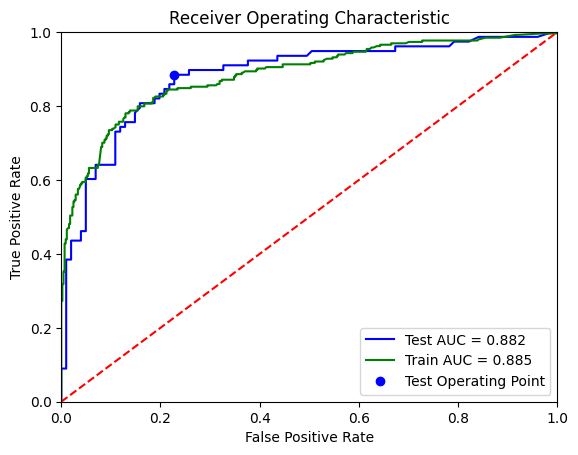

In [9]:
plt.title('Receiver Operating Characteristic')

plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' % test_roc_auc)
plt.plot(train_fpr, train_tpr, 'g', label = 'Train AUC = %0.3f' % train_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.plot(test_operating_point_fpr,test_operating_point_tpr, 'bo', label=f'Test Operating Point')
#plt.plot(train_operating_point_fpr,train_operating_point_tpr, 'go', label=f'Train Operating Point')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()

In [10]:
y_test_preds = (y_test_preds_proba[:,1] > test_threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {test_threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.169
  tn 78   fp 23 
  fn 10   tp 68 

Bal Acc: 0.822, Pre: 0.747, Rec: 0.872, F1 Micro: 0.816


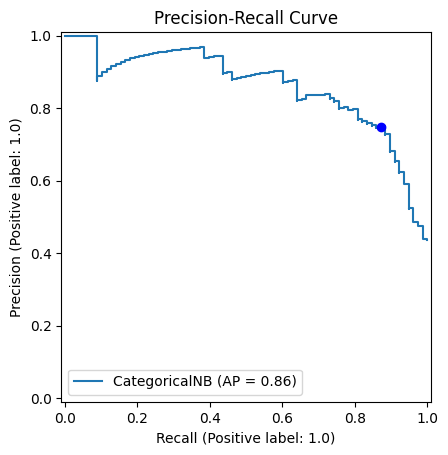

In [11]:
# Plot the precision-recall curve
display = ms.PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'bo', label=f'Test Operating Point')
plt.show()

In [12]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > test_threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds


In [13]:
df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.bayesian.csv", index=False)